In [1]:
import os
import random
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass



In [2]:
@dataclass
class Command:
    vocab_file: str
    dict_file: str
    use_gpu: bool = False
    interactive: bool = False
    shmem: bool = False
    multi_color: bool = False
    sentence: bool = False
    suppress_output = False
    seed: int = -1

def form_command(c: Command): 
    cmd = [f'./solver -d {c.dict_file} -v {c.vocab_file}']
    if c.use_gpu:
        cmd.append('-g')
    if c.interactive:
        cmd.append('-i')
    if c.shmem:
        cmd.append('-m')
        c.use_gpu = True
    if c.multi_color:
        cmd.append('-c')
        c.use_gpu = True
    if c.sentence:
        cmd.append('-t')
    if c.suppress_output:
        cmd.append('-o')
    if c.seed != -1:
        cmd.extend(['-s', f'{c.seed}'])
    return ' '.join(cmd).split(' ')

def parse_iteration_info(out: str, use_gpu: bool):
    ret = {}
    o = out.split('\n')
    expected_info = {}
    color_dist = {}
    for i in range(len(o)):
        line = o[i]
        if 'Occupancy' in line:
            ret['occ'] = float(line.split(': ')[-1])
        elif 'Word' in line and 'Expected Information' in line:
            expected_info[line.split(' ')[1]] = float(line.split(' ')[-1])
            if not use_gpu:
              c = o[i + 1].split(' ')
              color_dist[line.strip().split(' ')[1]] = [int(i) for i in c[:-1]]
        elif 'Expected Information' in line:
            ret['I_e'] = float(line.split(': ')[-1])
        elif 'Actual Information' in line:
            ret['I_a'] = float(line.split(': ')[-1])
        elif 'Solver guessed' in line:
            ret['guess'] = line.split(': ')[-1].strip()
        elif 'Solver Iteration Time' in line:
            ret['time'] = float(line.split(': ')[-1])
        elif 'Dict Size' in line:
            ret['old_dict_size'] = int(line.split(': ')[1].split(' ')[0])
            ret['new_dict_size'] = int(line.split(': ')[-1])
            break
    ret['info_dist'] = expected_info
    ret['color_dist'] = color_dist
    return ret

def run_command(c: Command):
    cmd = form_command(c)
    output = subprocess.check_output(cmd).decode()
    output = output.split('\n\n')
    ret = {}
    word = output[0]
    if 'Actual word' in word:
        ret['word'] = word.split(': ')[-1].strip()

    e2e_info = output[-1].split('\n')
    for line in e2e_info:
      if 'Solved in' in line:
          ret['iterations'] = int(line.split(' ')[-1])
      elif 'End to End' in line:
          ret['e2e_time'] = float(line.split(': ')[-1])

    iteration_info = output[1:-1]
    for i in range(len(iteration_info)):
        ret[f'iteration_{i}'] = parse_iteration_info(iteration_info[i], c.use_gpu)
    return ret


In [10]:
c = Command(vocab_file='./basic_dictionary/vocab.txt',
            dict_file = './basic_dictionary/potential_words.txt',
            use_gpu=True,
            shmem=True)

info = run_command(c)
print(info['iteration_1']['old_dict_size'])
print(info['iteration_1']['new_dict_size'])

56
3


In [13]:
# def calculate_speedup():
seeds = [random.randint(0, 1000) for i in range(10)]
speedups = []
shmem_speedup = []
multi_color_speedup = []
seq_runtimes = []
seq_throughput = []
gpu_throughput = []
s_iter = []
g_iter = []
throughput = []
vocab_file = './basic_dictionary/vocab.txt'
dict_file = './basic_dictionary/potential_words.txt'
total_results = []
for seed in seeds:
    seq = Command(vocab_file=vocab_file,
            dict_file = dict_file,
            seed=seed)
    gpu = Command(vocab_file=vocab_file,
            dict_file = dict_file,
            seed=seed,
            use_gpu=True)
    shmem = Command(vocab_file=vocab_file,
            dict_file = dict_file,
            seed=seed,
            shmem=True)
    multi_color = Command(vocab_file=vocab_file,
            dict_file = dict_file,
            seed=seed,
            multi_color=True)
    
    results = {}
    results['seq'] = run_command(seq)
    results['gpu'] = run_command(gpu)
    results['shmem'] = run_command(shmem)
    results['multi_color'] = run_command(multi_color)
    total_results.append(results)
    print(results['seq']['word'])
    speedups.append(results['seq']['e2e_time']/ results['gpu']['e2e_time'])
    shmem_speedup.append(results['seq']['e2e_time']/ results['shmem']['e2e_time'])
    multi_color_speedup.append(results['seq']['e2e_time']/ results['multi_color']['e2e_time'])
    seq_runtimes.append(results['seq']['e2e_time'])

    s_iter.append(results['seq']['iterations'])
    g_iter.append(results['gpu']['iterations'])

    s_t = []
    g_t = []
    for it in range(results['seq']['iterations']):
      s_t.append(results['seq'][f'iteration_{it}']['old_dict_size'] / results['seq'][f'iteration_{it}']['time'])
      g_t.append(results['gpu'][f'iteration_{it}']['old_dict_size'] / results['gpu'][f'iteration_{it}']['time'])
      
    seq_throughput.append(s_t)
    gpu_throughput.append(g_t)
    # results['shmem'] = run_command(shmem)
    # results['color'] = run_command(multi_color)
    # columns = ['seq', 'gpu']
    # index = np.arange(len(columns))
    # plt.bar(index, [results['seq']['e2e_time'], results['gpu']['e2e_time']])
    # plt.show()
    # plt.bar(results['gpu']['e2e_time'])

print(f'Average Speedup: {np.mean(speedups)}')
print(f'Average Shmem Speedup: {np.mean(shmem_speedup)}')
print(f'Average Multi Color Speedup: {np.mean(multi_color_speedup)}')
print(f'Seq Iterations: {np.mean(s_iter)}')
print(f'GPU Iterations: {np.mean(g_iter)}')
# print(f'Sequential Throughput: {[np.mean(i) * 10**9 for i in np.array(seq_throughput).T]}')
# print(f'GPU Throughput: {[np.mean(i) * 10**9 for i in np.array(gpu_throughput).T]}')

floor
fussy
given
gnash
fishy
stale
inept
abled
final
lemon
Average Speedup: 9.776277213044189
Average Shmem Speedup: 13.81681175354868
Average Multi Color Speedup: 9.061217673359732
Seq Iterations: 3.6
GPU Iterations: 3.6


[{'seq': [20565188525.0], 'gpu': [1790371434.0], 'shmem': [1811826924.0], 'multi_color': [1952195185.0]}, {'seq': [121135.0], 'gpu': [412244.0], 'shmem': [358617.0], 'multi_color': [311607.0]}, {'seq': [31851.0], 'gpu': [291126.0], 'shmem': [207175.0], 'multi_color': [191016.0]}, {'seq': [], 'gpu': [], 'shmem': [], 'multi_color': []}, {'seq': [], 'gpu': [], 'shmem': [], 'multi_color': []}]


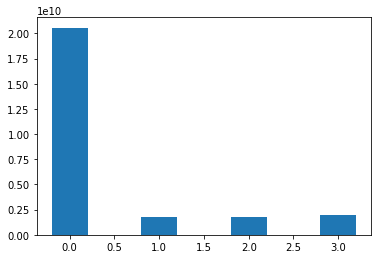

In [12]:
iteration_level_runtimes = [{'seq': [], 'gpu': [], 'shmem': [], 'multi_color': []} for _ in range(5)] 
for word_index in range(len(total_results)):
    word_data = total_results[word_index]
    runtimes = {'seq': [], 'gpu': [], 'shmem': [], 'multi_color': []}
    for key in runtimes.keys():
        for iteration in range(word_data[key]['iterations']):
            iteration_level_runtimes[iteration][key].append(word_data[key][f'iteration_{iteration}']['time'])

print(iteration_level_runtimes)
columns = ['Sequential', 'Basic GPU', 'Shared Memory', 'Thread per Color']
for iteration in range(len(iteration_level_runtimes)):
    info = []
    for key in iteration_level_runtimes[iteration].keys():
      info.append(np.mean(iteration_level_runtimes[iteration][key]) / 10**9)
    # if(iteration != 0):
    plt.bar(np.arange(len(columns)), info, width = 0.4, label=iteration)
plt.show()

basic
shmem
multi_color


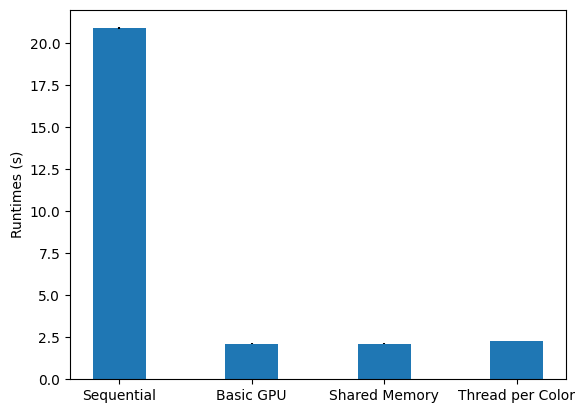

In [32]:
columns = ['Basic GPU', 'Shared Memory', 'Thread per Color']
means = [np.mean(speedups), np.mean(shmem_speedup), np.mean(multi_color_speedup)]
std = [np.std(speedups), np.std(shmem_speedup), np.std(multi_color_speedup)]
fig, ax = plt.subplots(1,1) 

# ax.bar(np.arange(len(columns)), means, yerr=std, width = 0.4)
# ax.set_xticks(np.arange(len(columns)))
# ax.set_xticklabels(columns)
# plt.show()

# seq_runtimes = [i / 10**9 for i in seq_runtimes]
columns = ['Sequential', 'Basic GPU', 'Shared Memory', 'Thread per Color']
data = {'basic': speedups, 'shmem': shmem_speedup, 'multi_color': multi_color_speedup}
runtimes = {'basic': [], 'shmem': [], 'multi_color': []}
for i in range(len(speedups)):
    for k in runtimes.keys():
        for j in range(len(data[k])):
            runtimes[k].append(seq_runtimes[j] / data[k][j] )


means = []
std = []
means.append(np.mean(seq_runtimes))
std.append(np.std(seq_runtimes))
for k in runtimes.keys():
    print(k)
    means.append(np.mean(runtimes[k]))
    std.append(np.std(runtimes[k]))
ax.set_ylabel('Runtimes (s)')
ax.bar(np.arange(len(columns)), means, yerr=std, width = 0.4)
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
plt.show()


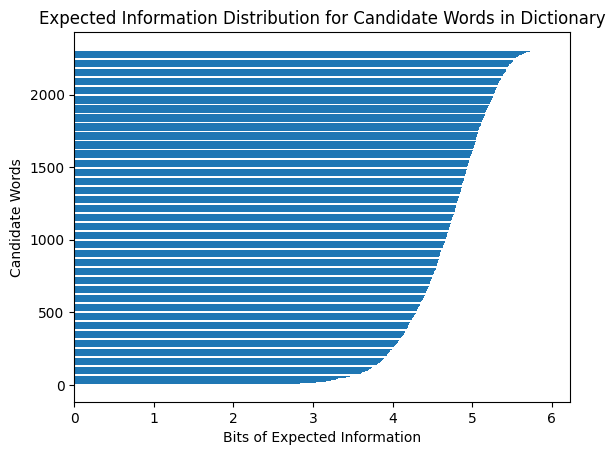

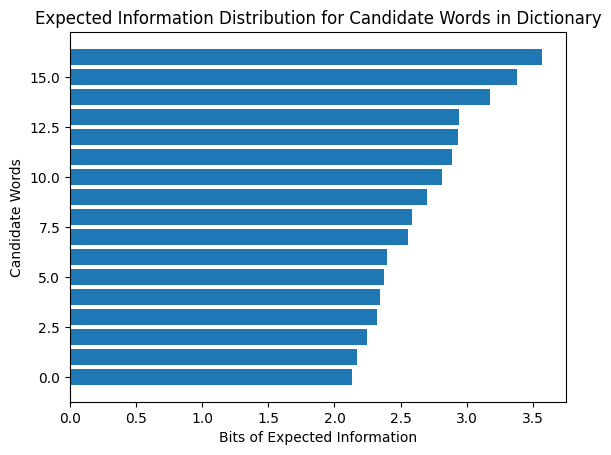

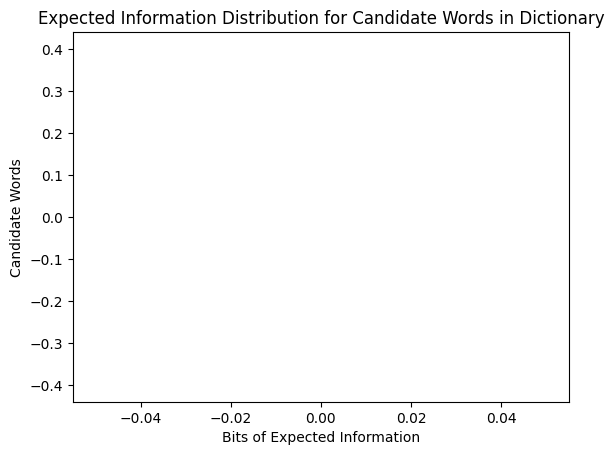

In [8]:
def plot_expected_info_distribution():
  seeds = [random.randint(0, 1000) for i in range(1)]
  for seed in seeds:
    gpu = Command(vocab_file='./basic_dictionary/vocab.txt',
              dict_file = './basic_dictionary/potential_words.txt',
              seed=seed,
              use_gpu=True)
    g = run_command(gpu)
    for i in range(g['iterations']):
      info = g[f'iteration_{i}']['info_dist']
      index = np.arange(len(info))
      plt.barh(index, list(info.values()))
      plt.title('Expected Information Distribution for Candidate Words in Dictionary')
      plt.ylabel('Candidate Words')
      plt.xlabel('Bits of Expected Information')
      plt.show()
plot_expected_info_distribution()

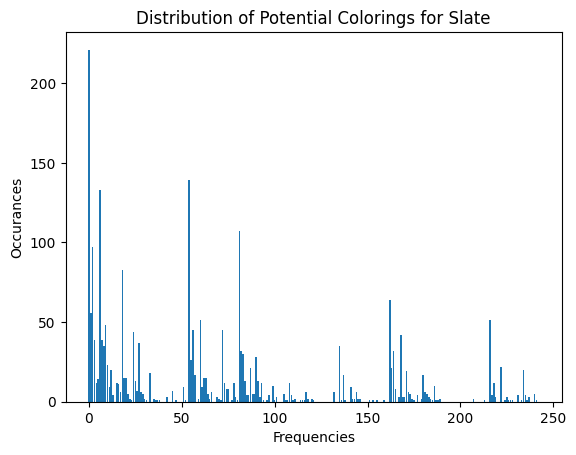

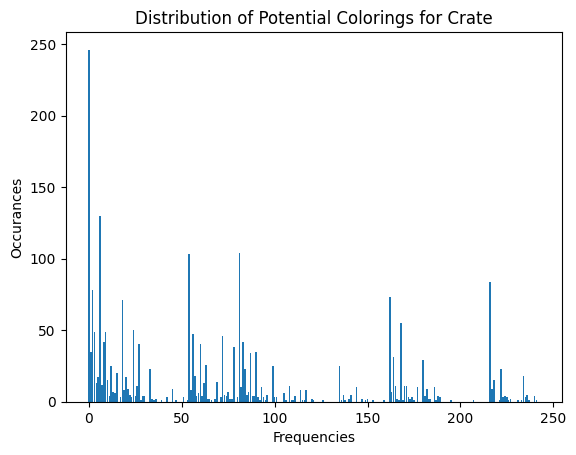

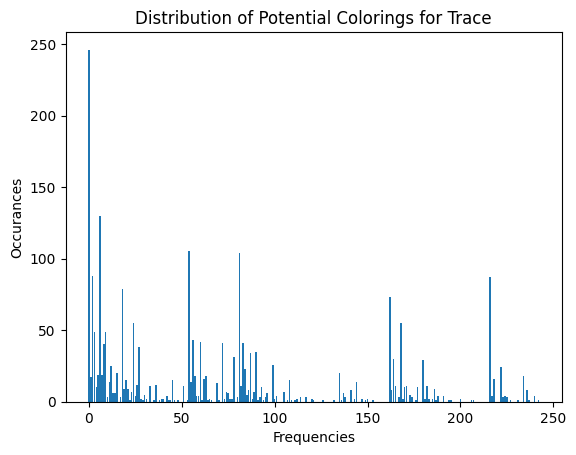

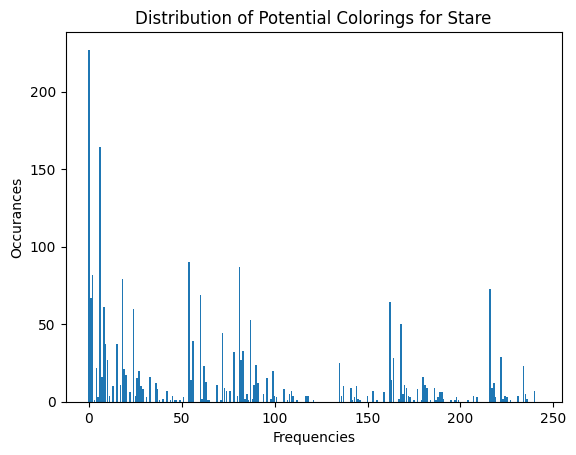

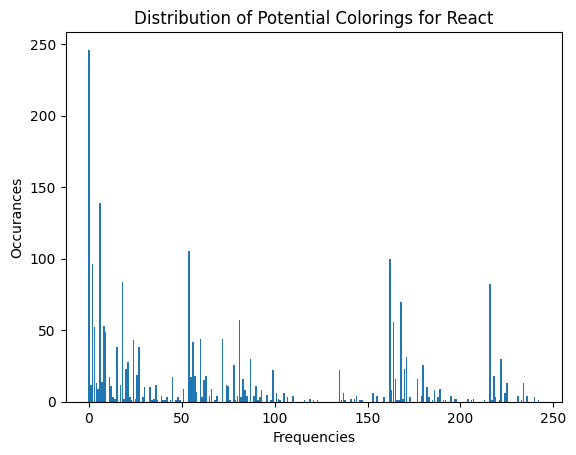

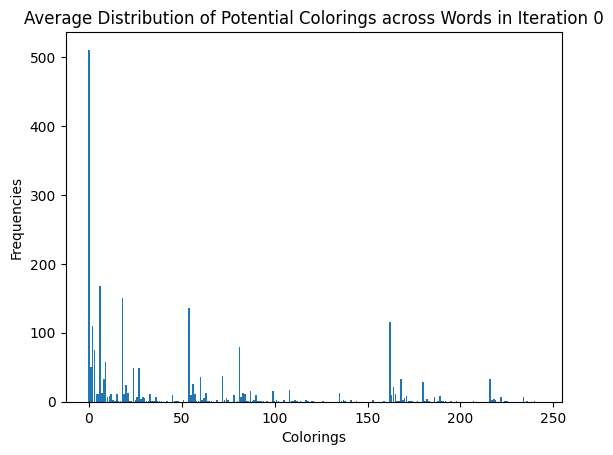

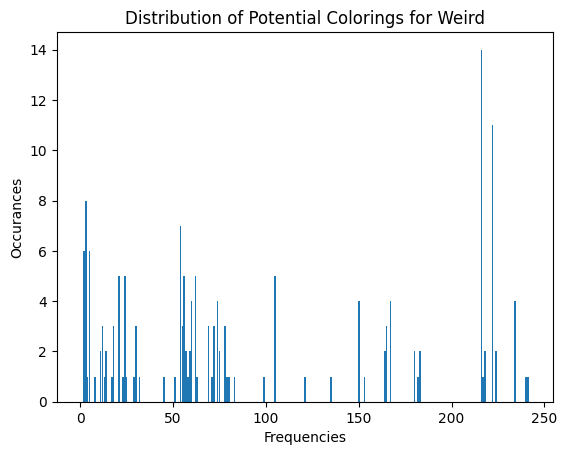

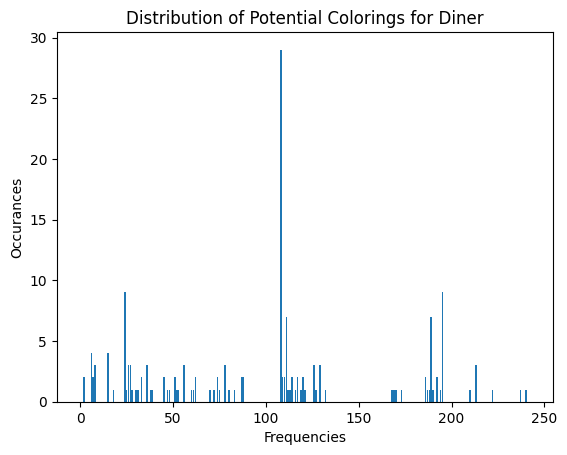

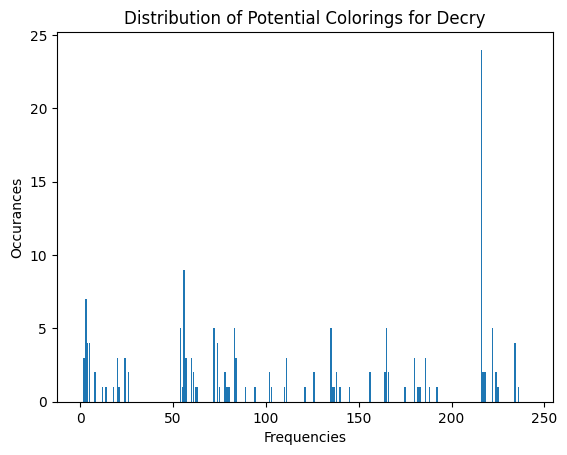

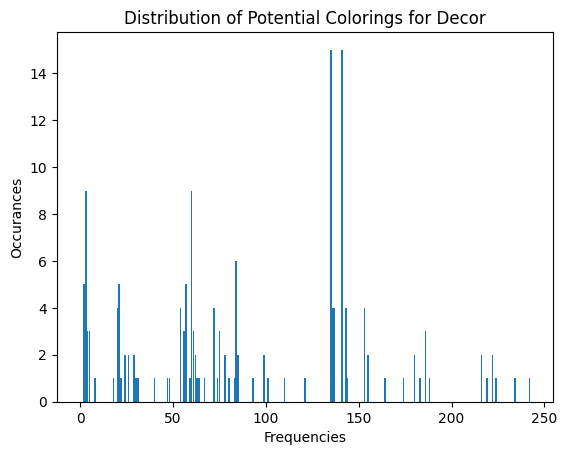

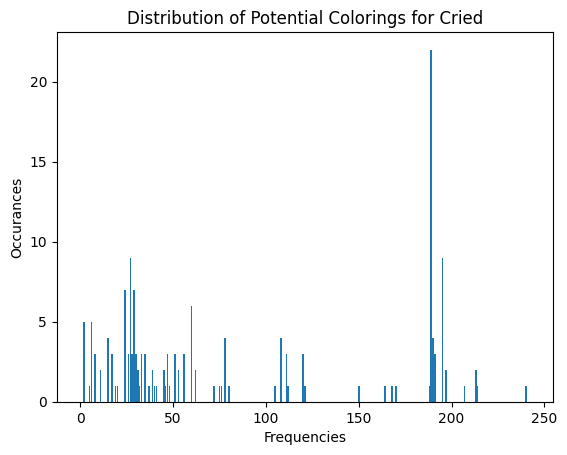

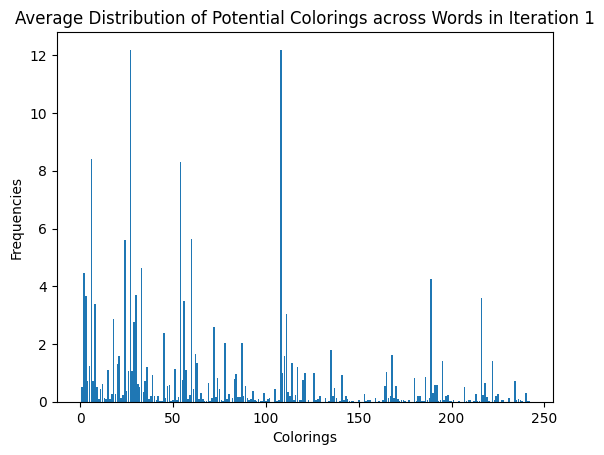

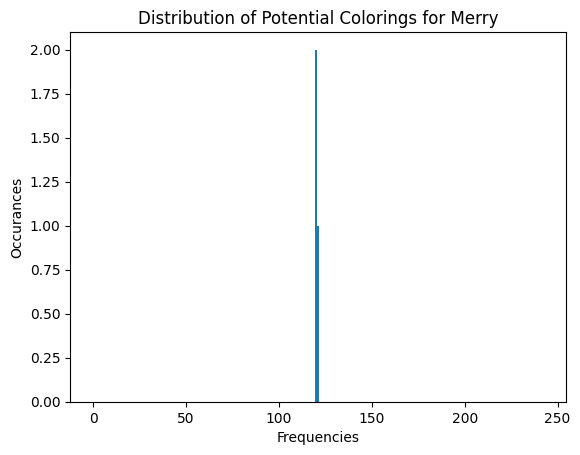

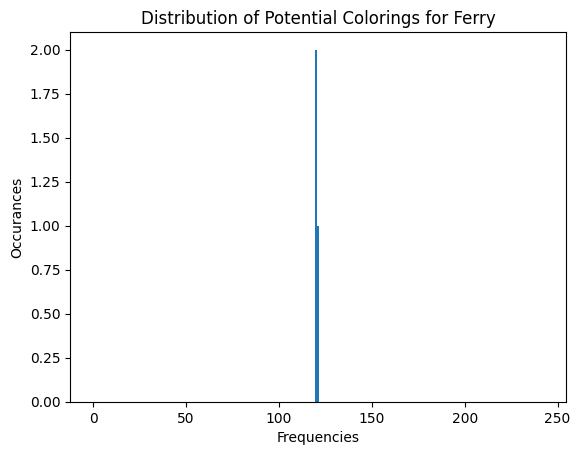

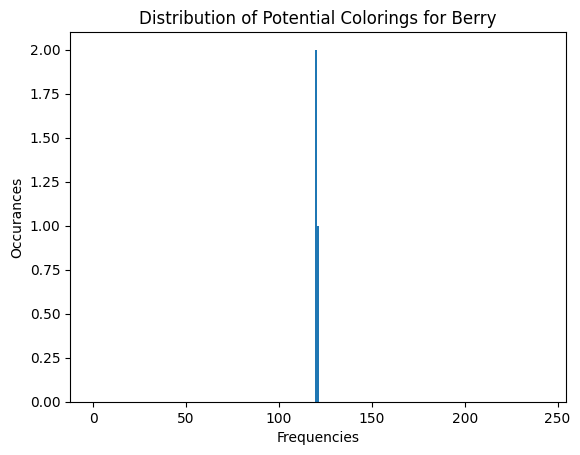

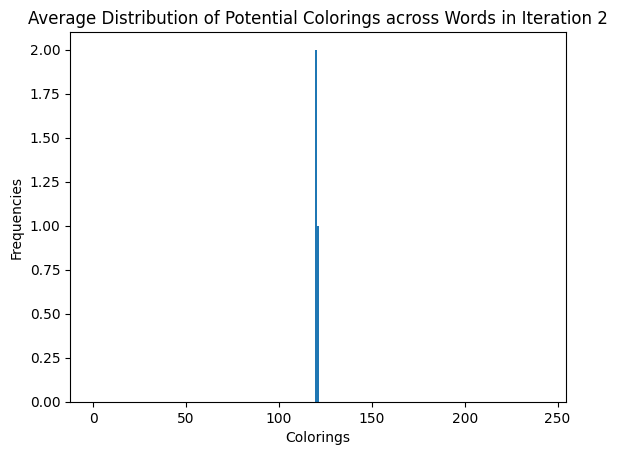

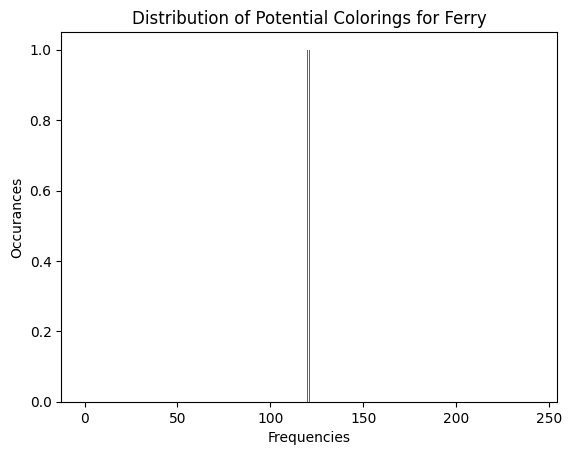

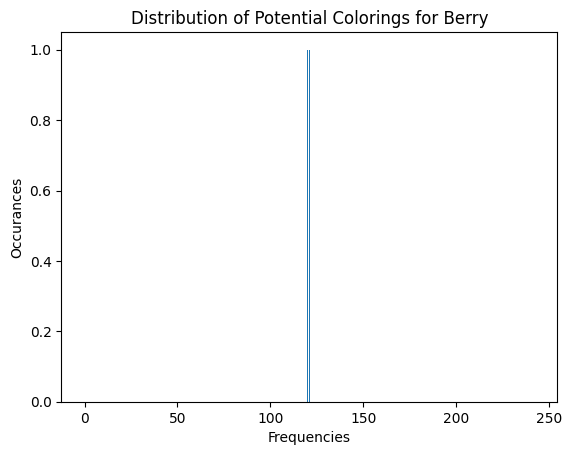

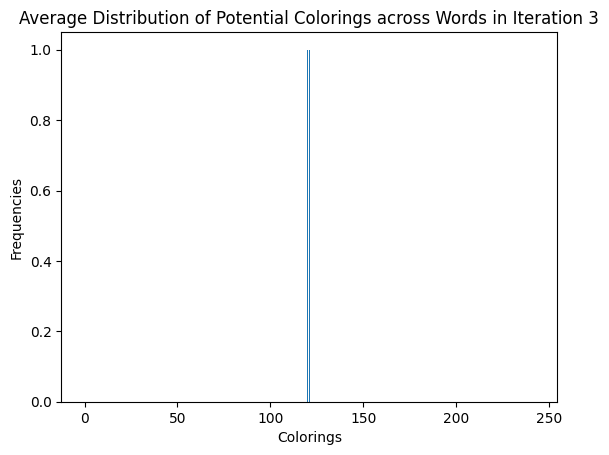

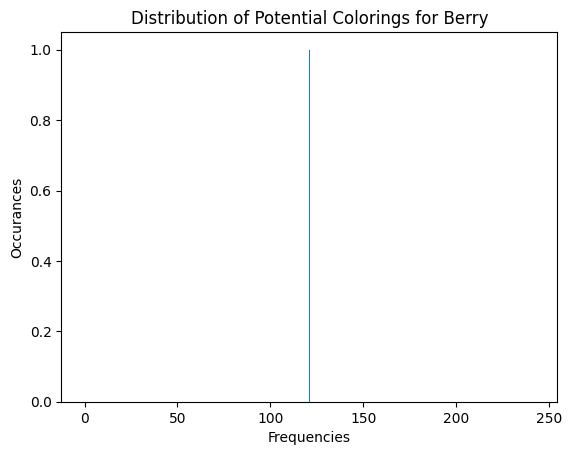

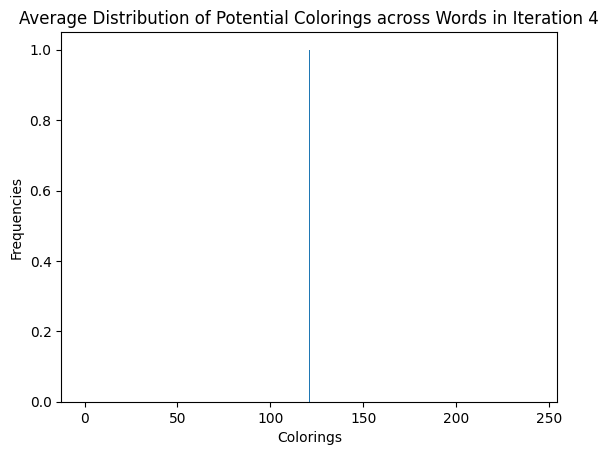

In [9]:
def plot_color_distribution():
  seeds = [random.randint(0, 1000) for i in range(1)]
  for seed in seeds:
    seq = Command(vocab_file='./basic_dictionary/vocab.txt',
              dict_file = './basic_dictionary/potential_words.txt',
              seed=seed)
    s = run_command(seq)
    for it in range(s['iterations']):
      info = s[f'iteration_{it}']['color_dist']
      num_graphs = 0
      max_graph = 5
      iteration_distribution = None
      for word in reversed(info.keys()):
        if iteration_distribution == None:
          iteration_distribution = [0] * len(info[word])
        for i in range(len(info[word])):
          iteration_distribution[i] += info[word][i] 
        if num_graphs < max_graph:
          index = np.arange(len(info[word]))
          plt.bar(index, info[word])
          plt.xlabel('Frequencies')
          plt.ylabel('Occurances')
          plt.title(f'Distribution of Potential Colorings for {word.title()}')
          plt.show()
        num_graphs += 1
      index = np.arange(len(iteration_distribution))
      plt.bar(index, np.array(iteration_distribution) / len(info.keys()))
      plt.xlabel('Colorings')
      plt.ylabel('Frequencies')
      plt.title(f'Average Distribution of Potential Colorings across Words in Iteration {it}')
      plt.show()
plot_color_distribution()

In [4]:
def generate_word(word_length: int, characters: str):
    ret = ""
    for _ in range(word_length):
      ret += random.choice(characters)
    return ret

def generate_sentence(vocab_length: int, vocab: set, single_word: bool = True):
    ret = ""
    vocab = list(vocab)
    for _ in range(vocab_length):
      ret += random.choice(vocab)
      if not single_word:
        ret += " "
    return ret

def generate_data_set(vocab_size: int, potential_words: int, max_word_length: int, vocab_length: int, dataset_path: str):
    letters = "abcdefghijklmnopqrstuvwxyz"
    vocab = set()
    for _ in range(vocab_size):
       w = generate_word(random.randint(1, max_word_length), letters)
       while w in vocab:
          w = generate_word(random.randint(1, max_word_length), letters)
       vocab.add(w)

    words = set()
    for _ in range(potential_words):
       w = generate_sentence(vocab_length, vocab, max_word_length == 1)
       while w in words:
          w = generate_sentence(vocab_length, vocab, max_word_length == 1)
       words.add(w)
      
    with open(f'{dataset_path}/vocab.txt', 'w') as f:
      for line in vocab:
          f.write(f"{line}\n")
    with open(f'{dataset_path}/potential_words.txt', 'w') as f:
      for line in words:
          f.write(f"{line}\n")

        
            
generate_data_set(10, 100, 1, 5, './test_dictionary')
    
    

In [31]:
vc = Command(vocab_file='./test_dictionary/vocab.txt',
            dict_file = './test_dictionary/potential_words.txt',
            shmem=True, 
            sentence=True)

info = run_command(c)
print(info)

{'word': 'ascot', 'iterations': 3, 'e2e_time': 2032246203.0, 'iteration_0': {'occ': 0.00198025, 'I_e': 5.9392, 'time': 1709215645.0, 'guess': 'slate', 'I_a': 8.85487}, 'iteration_1': {'occ': 2.71267e-05, 'I_e': 2.32193, 'time': 206900.0, 'guess': 'angst', 'I_a': 2.32193}, 'iteration_2': {'occ': 2.71267e-05, 'I_e': 0.0, 'time': 182556.0, 'guess': 'ascot', 'I_a': 0.0}}
